In [6]:
import cv2
import numpy as np

filename = 'reference_img.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# Result is dilated for marking the corners
dst = cv2.dilate(dst, None)

# Threshold for an optimal value; may vary depending on the image.
img[dst > 0.01 * dst.max()] = [0, 0, 255]

cv2.imshow('dst', img)
cv2.imwrite('harris_result.png', img)  # This saves the result image

if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()


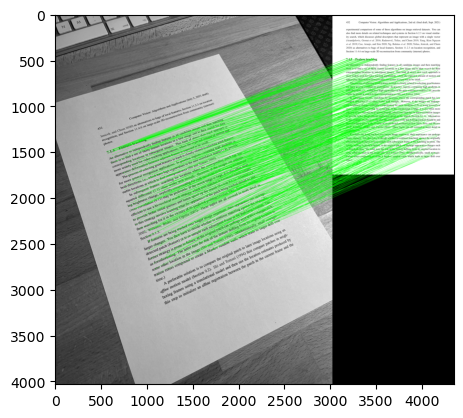

In [14]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10

img1 = cv.imread('align_this.jpg', cv.IMREAD_GRAYSCALE)      # queryImage
img2 = cv.imread('reference_img.png', cv.IMREAD_GRAYSCALE)    # trainImage


# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h, w = img1.shape
    pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts, M)

    img2_poly = cv.polylines(img2.copy(), [np.int32(dst)], True, 255, 3, cv.LINE_AA)
    draw_params = dict(matchColor=(0,255,0), # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask, # draw only inliers
                       flags=2)
    img3 = cv.drawMatches(img1, kp1, img2_poly, kp2, good, None, **draw_params)
    plt.imshow(img3, 'gray'), plt.show()
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None
    draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       matchesMask=matchesMask,
                       flags=2)
    img3 = cv.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
    plt.imshow(img3, 'gray'), plt.show()
